In [1]:
%load_ext autoreload
%autoreload 2

In [66]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [61]:
from expertise.data import load_all_predictors, load_feature_data
from expertise.predictors import train_boosted, create_predicted_dataframe, train_regression_tree, predict_aggregate, train_random_predictor
from expertise.multical import assess_callibration
from expertise.utils import subsample_rows

## Setup Data

In [20]:
max_depth = 5
bins = 10

In [12]:
tidy = load_all_predictors()

In [26]:
x_train, y_train, x_train_id, x_test, y_test, x_test_id = load_feature_data()
test_predictions = train_boosted(x_train,y_train,x_test,max_depth)
m = create_predicted_dataframe(test_predictions,x_test_id,bins)
tidy = tidy.merge(m, on='file_id', how='left')

LS:  35%|███▌       35/100 00:17, Training Error=0.0115938

Early Termination at round: 36
Memory released!


In [37]:
tidy

,file_id,human.pred.c,human.pred.t12,human.pred.t4,human.pred.t8,pred_esc_random_forest,true_esc,pred_esc_naive bayes,pred_esc_logistic_regression,pred_esc_linear_svm,pred_esc_gradient_boosting,mc_pred,bin
0,321932871341684,1,1,1,1,0,0,1,1,1,1,0.013525,1
1,321933198008318,1,1,0,1,1,1,1,0,0,0,0.013525,1
2,324207107780927,1,0,0,0,1,0,1,1,1,1,0.013525,1
3,338180983050206,1,0,0,0,1,0,1,1,1,1,1.000000,10
4,338181036383534,0,1,1,0,1,0,1,1,1,1,0.998819,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
855,1036634413051119,0,0,0,0,0,0,0,0,0,1,0.013525,1
856,1036635499717677,0,1,1,1,0,0,0,0,0,0,0.013525,1
857,1038831612831399,0,0,0,0,0,0,0,0,0,0,0.000000,0
858,1038833189497908,1,1,0,0,1,0,1,1,1,1,1.000000,10


## Compare \mathcal{F}

In [81]:
boosted_predictor = assess_callibration(tidy,"human.pred.t12","bin","true_esc")
boosted_predictor

0.6976744186046511

In [82]:
num_trees = 10
num_clusters = 2
for i in range(1,num_trees+1):
    tidy['rt_{}'.format(i)] = subsample_rows(train_regression_tree(x_train,y_train,x_test,i),tidy,x_test_id)
tidy['cluster'] = predict_aggregate(tidy[['rt_{}'.format(i) for i in range(1,num_trees+1)]].to_numpy(),num_clusters)

In [83]:
top_k_predictor = assess_callibration(tidy,"human.pred.t12","cluster","true_esc")
top_k_predictor

0.6767441860465115

In [101]:
pred_by_trees = []
for num_trees in range(2,11):
    num_clusters = 2
    for i in range(1,num_trees+1):
        tidy['rt_{}'.format(i)] = subsample_rows(train_regression_tree(x_train,y_train,x_test,i),tidy,x_test_id)
    tidy['cluster'] = predict_aggregate(tidy[['rt_{}'.format(i) for i in range(1,num_trees+1)]].to_numpy(),num_clusters)
    top_k_predictor = assess_callibration(tidy,"human.pred.t12","cluster","true_esc")
    pred_by_trees.append(top_k_predictor)

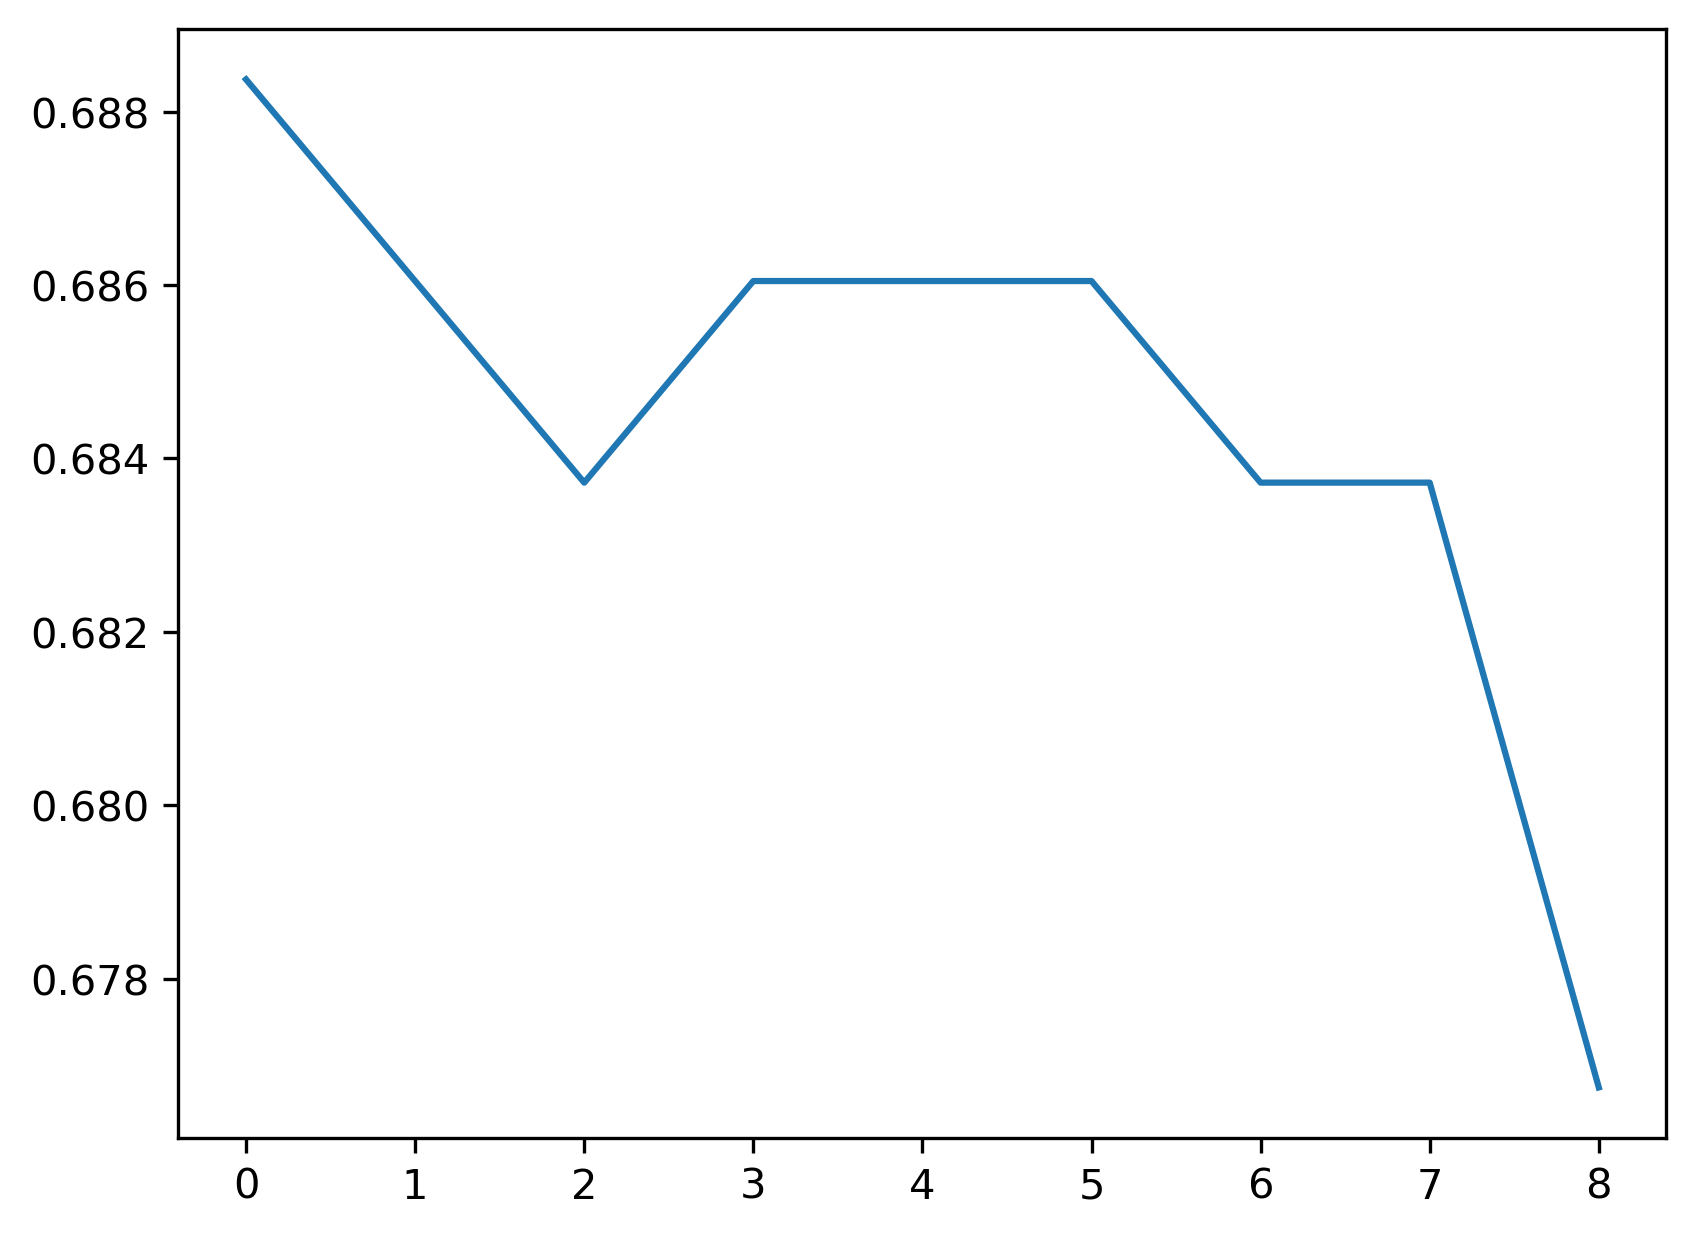

In [103]:
plt.plot(pred_by_trees)

In [122]:
individual_tree_perf = assess_callibration(tidy,"rt_1","rt_1","true_esc")
bagged_trees_perf = assess_callibration(tidy,"cluster","cluster","true_esc")
tidy['boosted_pred'] = tidy['mc_pred'].round()
boosted_trees_perf = assess_callibration(tidy,"boosted_pred","boosted_pred","true_esc")
individual_tree_perf,bagged_trees_perf, boosted_trees_perf

(0.6813953488372093, 0.6186046511627907, 0.6558139534883721)

In [132]:
assess_callibration(tidy,"human.pred.t12","boosted_pred","true_esc")


On val 0.0
On val 1.0


0.6976744186046512

## Impact of Multicallibration

In [115]:
tidy['cluster'] = train_random_predictor(tidy['true_esc'],0.7)
random_predictor = assess_callibration(tidy,"human.pred.t12","cluster","true_esc")
random_predictor

0.6837209302325582

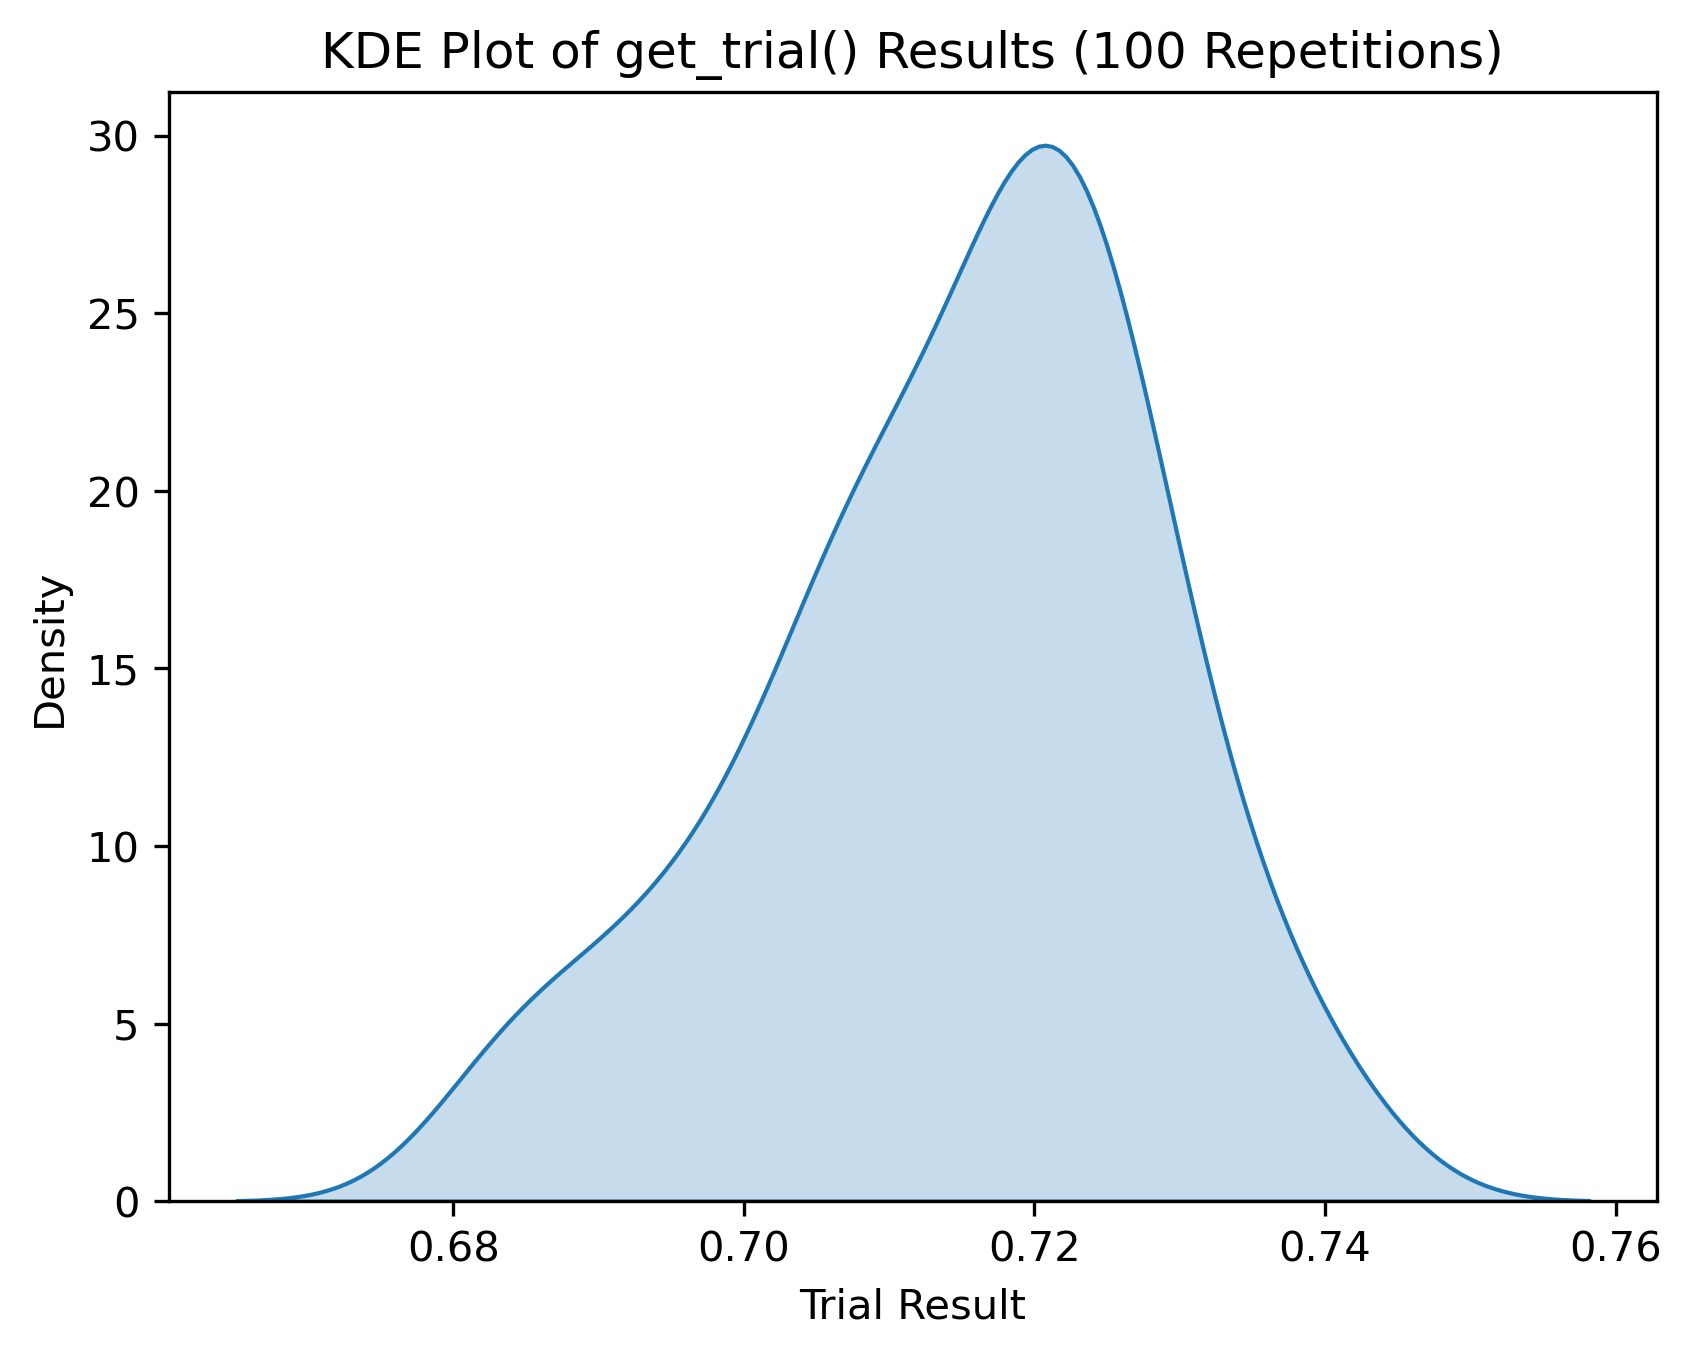

In [116]:
num_trials = 100
accuracy = 0.65
trials = []
for i in range(num_trials):
    tidy['cluster'] = train_random_predictor(tidy['true_esc'],accuracy)
    random_predictor = assess_callibration(tidy,"human.pred.t12","cluster","true_esc")
    trials.append(random_predictor)
sns.kdeplot(trials, shade=True)
plt.xlabel('Trial Result')
plt.ylabel('Density')
plt.title('KDE Plot of get_trial() Results (100 Repetitions)')
plt.show()

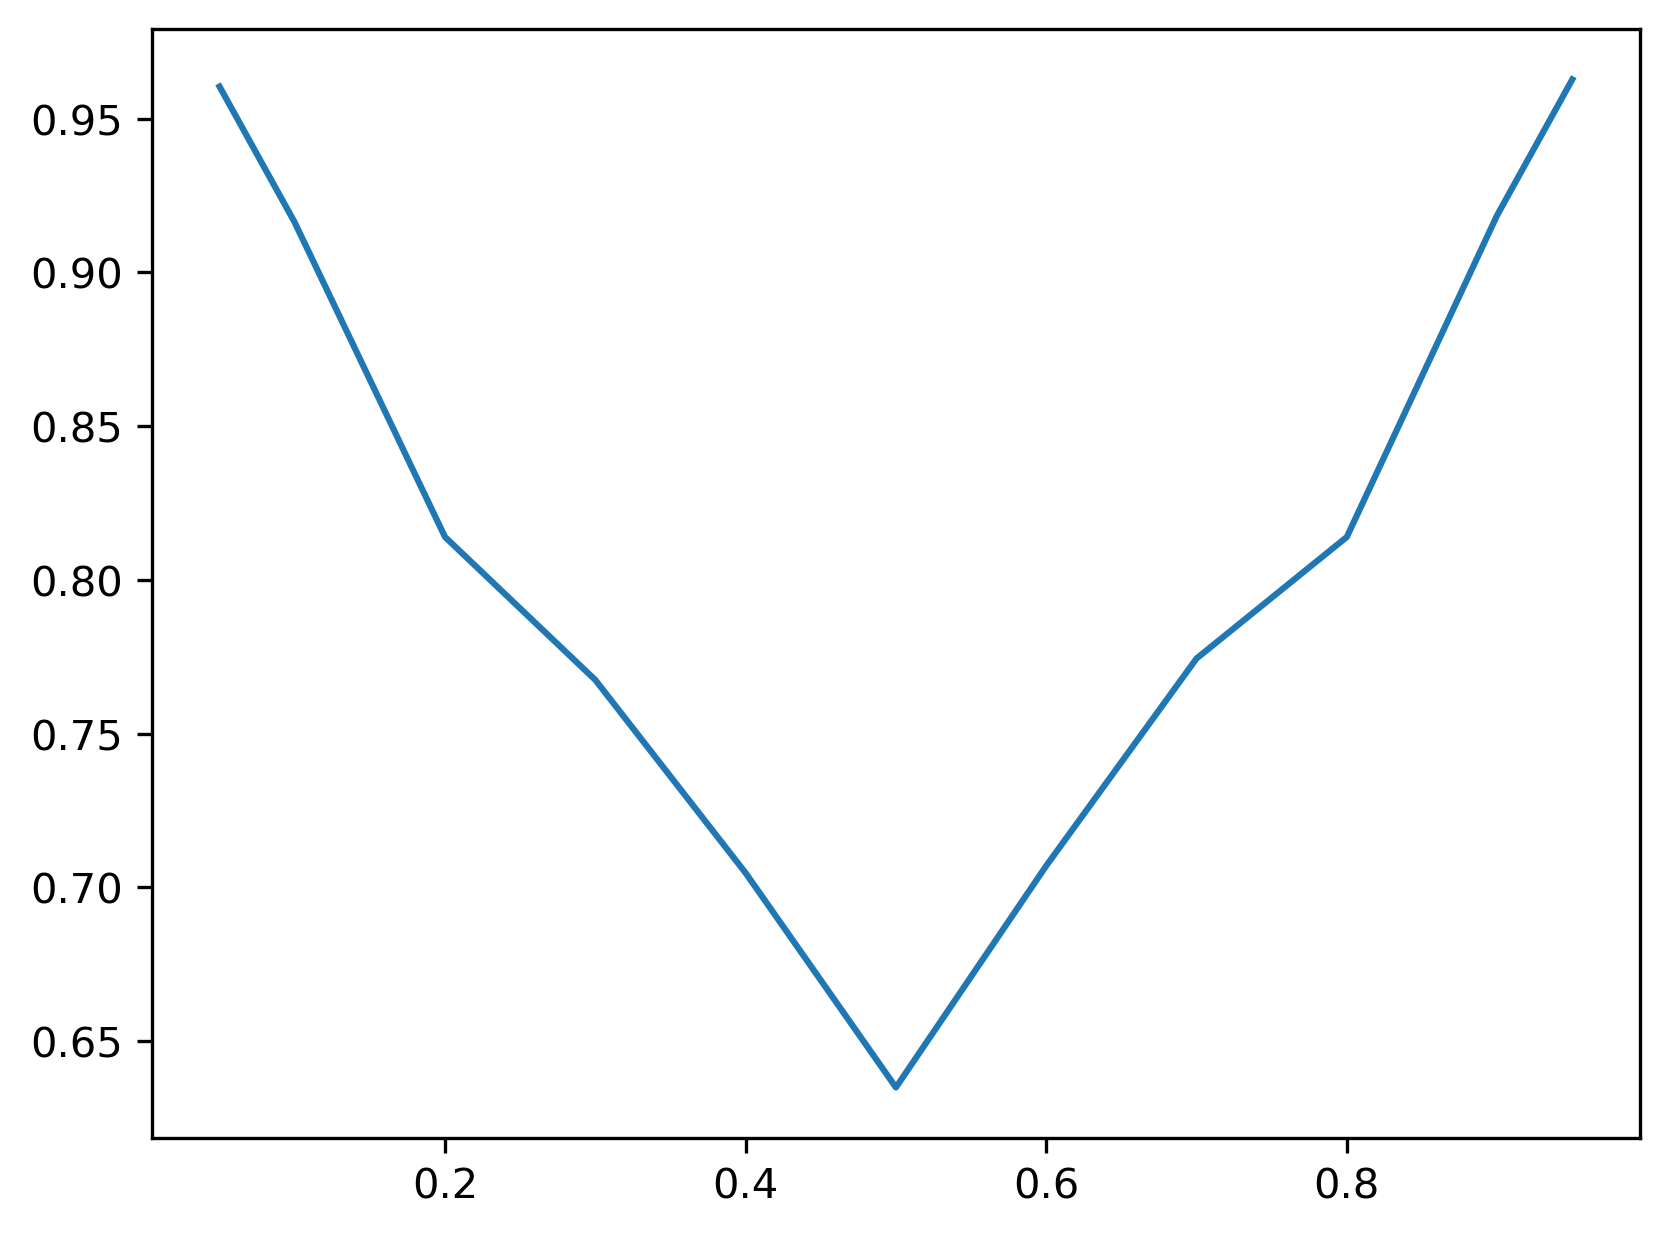

In [86]:
num_trials = 10
x_values = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95]
y_values = []
for accuracy in x_values:
    trials = []
    for i in range(num_trials):
        tidy['cluster'] = train_random_predictor(tidy['true_esc'],accuracy)
        random_predictor = assess_callibration(tidy,"human.pred.t12","cluster","true_esc")
        trials.append(random_predictor)
    y_values.append(np.max(trials))

plt.plot(x_values,y_values)

In [91]:
num_trials = 100
accuracy = 0.7
trials = []
for i in range(num_trials):
    tidy['cluster'] = train_random_predictor(tidy['true_esc'],accuracy)
    predictors_by_human = [assess_callibration(tidy,"human.pred.t{}".format(i),"cluster","true_esc") for i in [4,8,12]]
    trials.append(predictors_by_human)
trials = np.array(trials)

In [94]:
np.argmax(trials[:,0]),np.argmax(trials[:,1]),np.argmax(trials[:,2])

(62, 35, 62)

In [99]:
np.corrcoef(trials[:,0],trials[:,1])[0,1],np.corrcoef(trials[:,0],trials[:,2])[0,1],np.corrcoef(trials[:,1],trials[:,2])[0,1]

(0.5507097305367171, 0.509824906737115, 0.5345193427372451)

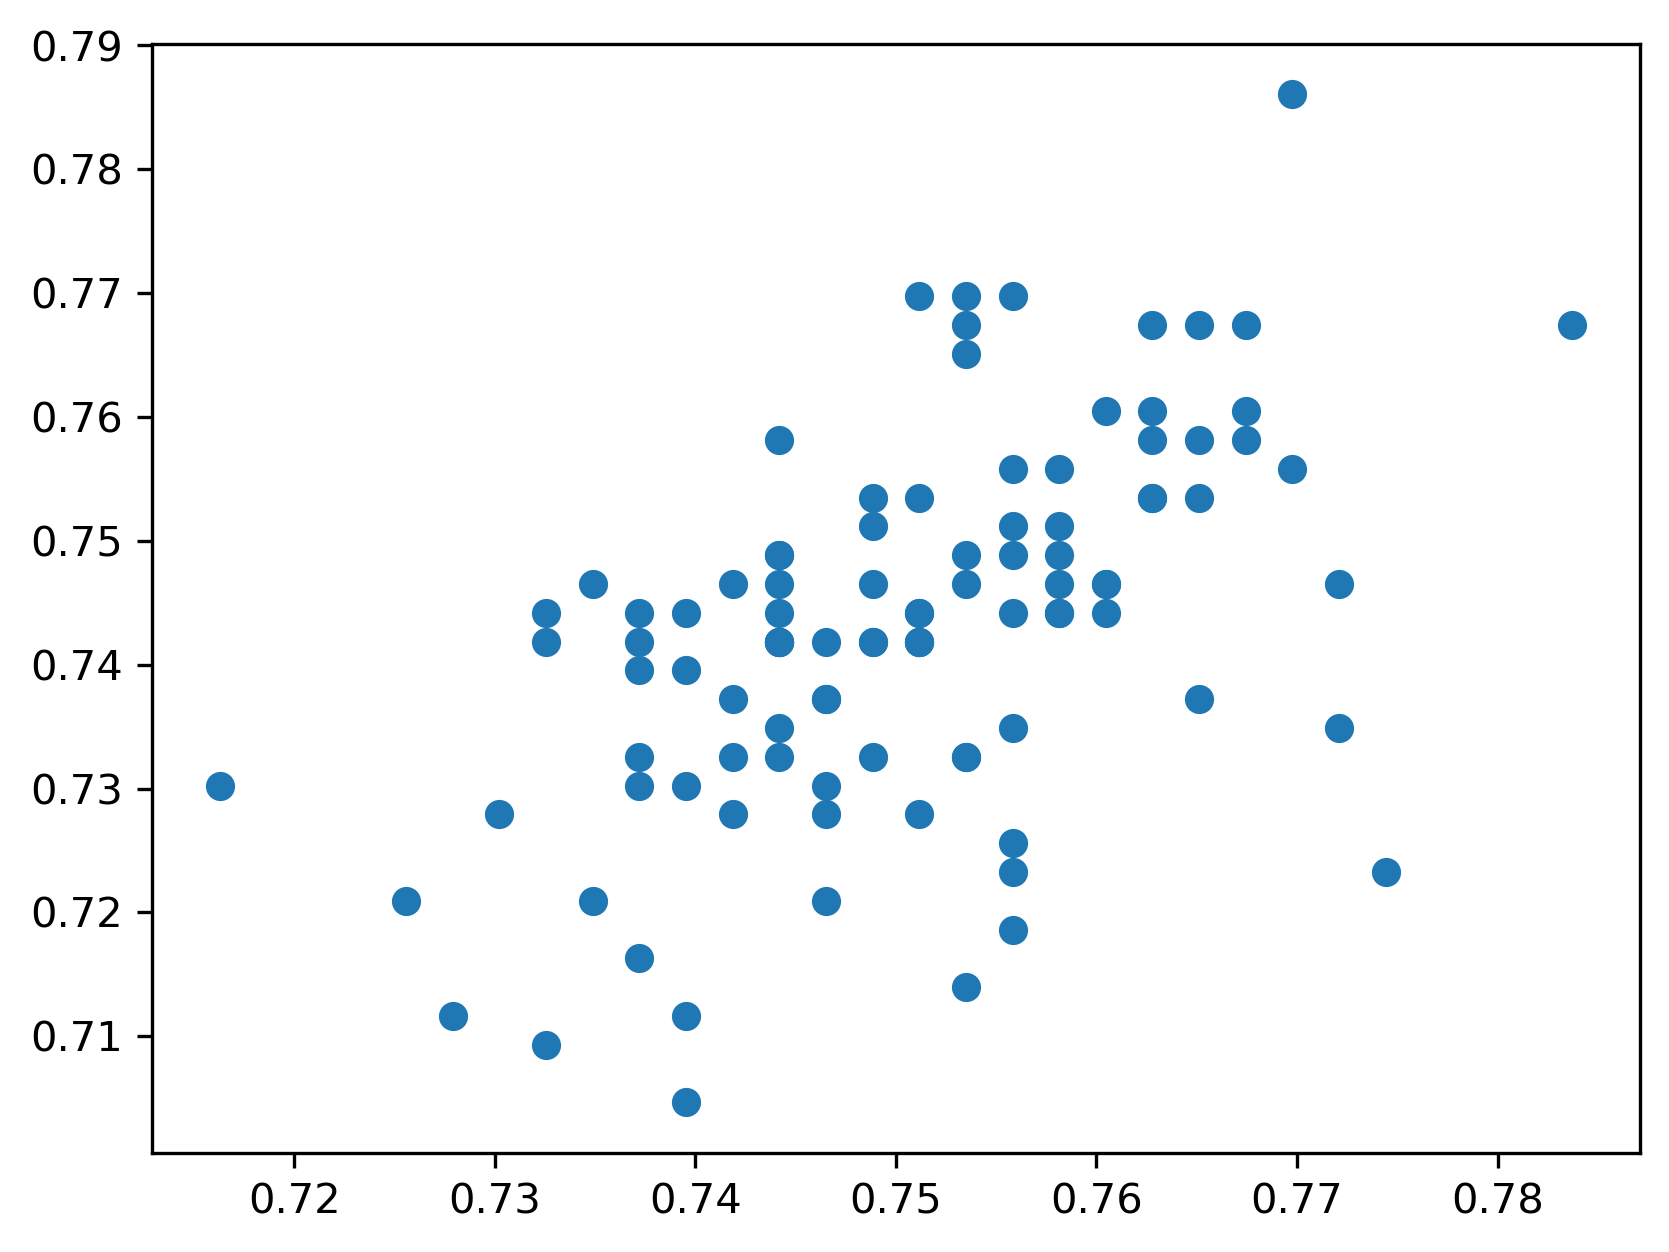

In [100]:
plt.scatter(trials[:,1],trials[:,2])